#News Category Classification

## Objective
The objective of the project is to implement news category classification model using transformers like BERT and ROBERTA

## Dataset Overview:
About 210k news headlines from HuffPost from 2012 and 2022 are included in this dataset. There are roughly 200k headlines from 2012 to May 2018 and 10,000 headlines from May 2018 to 2022 due to website modifications.

## Data import and cleaning

Importing the necesssay libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import torch
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

Reading json file

In [ ]:
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [ ]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


Check for missing values

In [ ]:
df.isnull().sum()

,0
link,0
headline,0
category,0
short_description,0
authors,0
date,0


Check for duplicate values

In [ ]:
df.duplicated().sum()

13

Since the values are less, dropping the values

In [ ]:
df.drop_duplicates(inplace=True) #dropping duplicates

Count of total categories available

In [ ]:
df["category"].value_counts()

,count
category,
POLITICS,35601
WELLNESS,17942
ENTERTAINMENT,17362
TRAVEL,9900
STYLE & BEAUTY,9811
PARENTING,8791
HEALTHY LIVING,6694
QUEER VOICES,6347
FOOD & DRINK,6340


## EDA

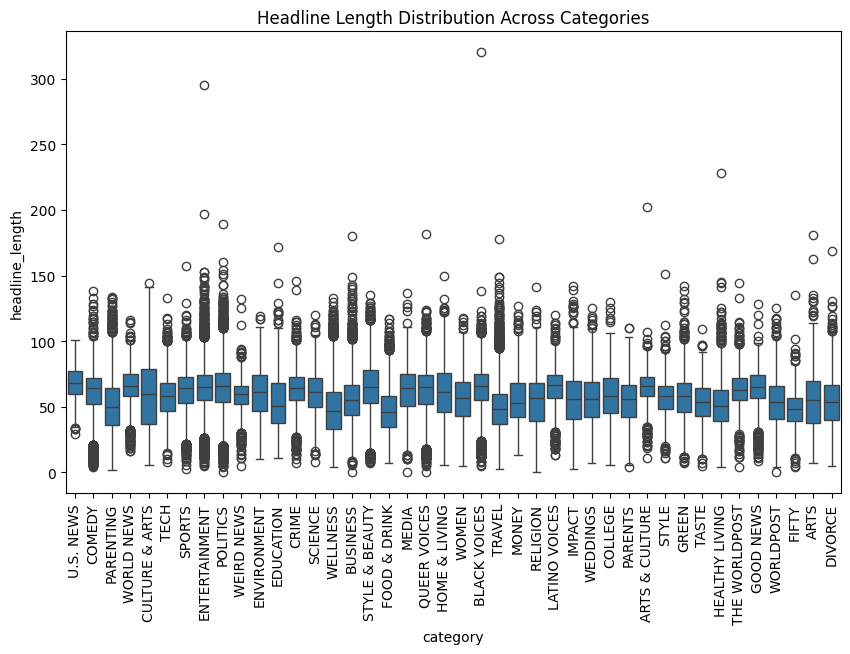

In [ ]:
# Explore the relationship between headline length and category
df["headline_length"] = df["headline"].apply(len) # length of headline
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="headline_length", data=df)
plt.title("Headline Length Distribution Across Categories")
plt.xticks(rotation=90)
plt.show()

count    209514.000000
mean         58.415376
std          18.808678
min           0.000000
25%          46.000000
50%          60.000000
75%          71.000000
max         320.000000
Name: headline_length, dtype: float64


<ipython-input-11-e90f10913c97>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['headline_length'])


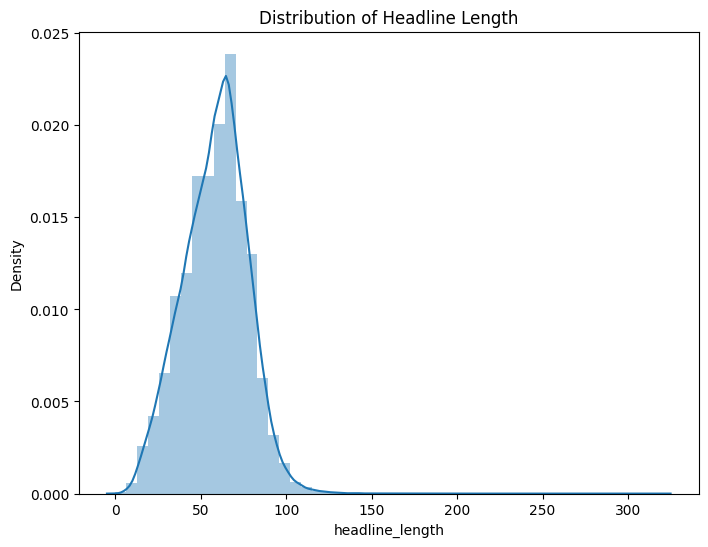

In [ ]:
# Analyzing the distribution of short and long headlines
print(df['headline_length'].describe())
plt.figure(figsize=(8,6))
sns.distplot(df['headline_length'])
plt.title('Distribution of Headline Length')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


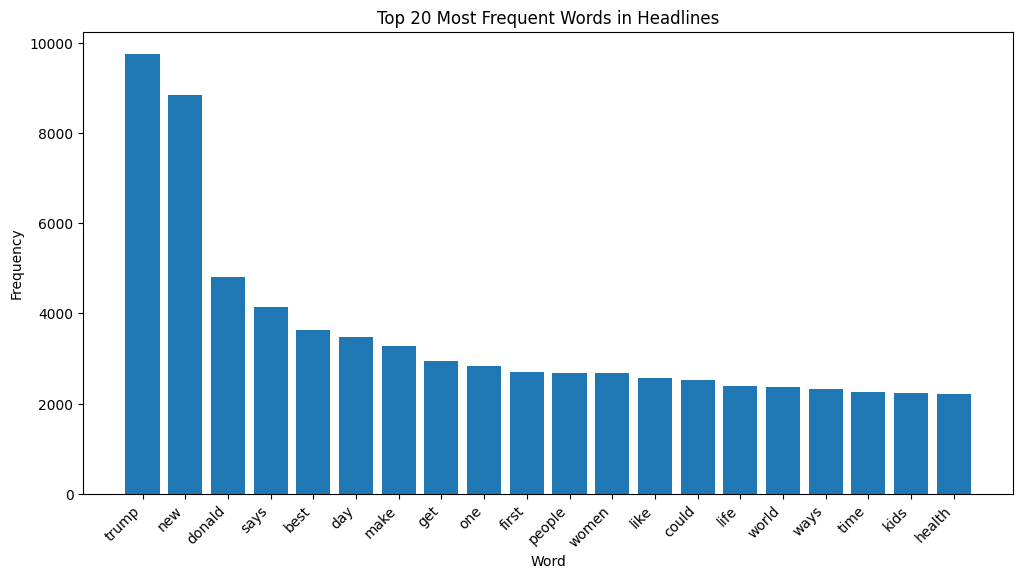

In [ ]:
# Analyze the most frequent words in headlines
from collections import Counter

# Combine all headlines into a single string
all_headlines = ' '.join(df['headline'])

# Tokenize the headlines
words = all_headlines.lower().split()

# Remove punctuation and stop words
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words if word.isalpha() and word not in stop_words]


# Count the word frequencies
word_counts = Counter(words)

# Get the 20 most frequent words
most_common_words = word_counts.most_common(20)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(*zip(*most_common_words))  # Unpack the list of tuples into two lists
plt.title('Top 20 Most Frequent Words in Headlines')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.show()

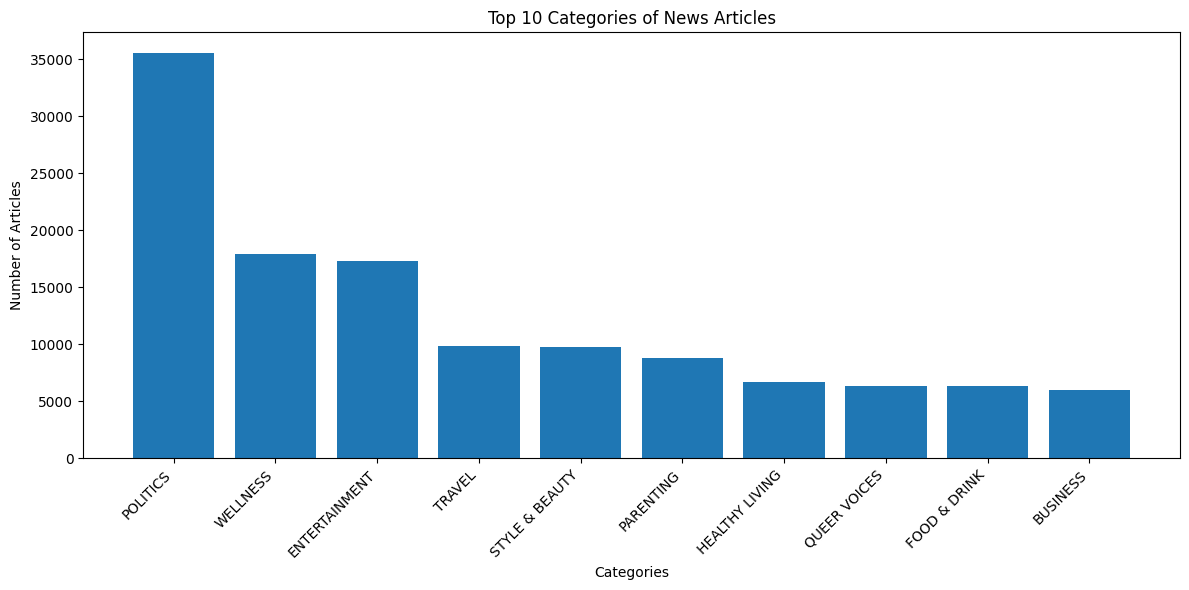

In [ ]:
#top 10 categories bar graph

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has a column named 'category'
top_10_categories = df['category'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_categories.index, top_10_categories.values)
plt.xlabel("Categories")
plt.ylabel("Number of Articles")
plt.title("Top 10 Categories of News Articles")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

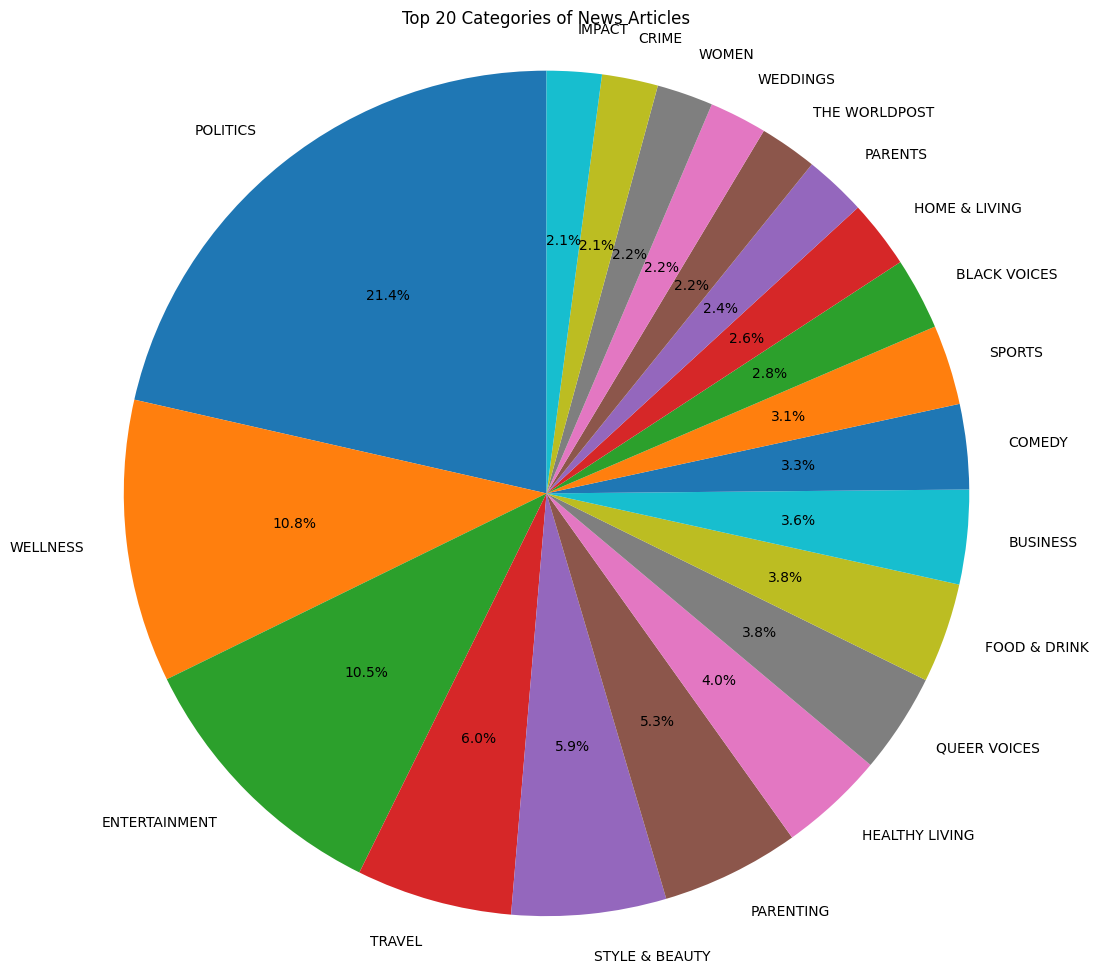

In [ ]:
# pie chart for top 20 categories

# Assuming 'df' is your DataFrame and it has a column named 'category'
top_20_categories = df['category'].value_counts().nlargest(20)

plt.figure(figsize=(12, 12))  # Adjust figure size for better visualization
plt.pie(top_20_categories.values, labels=top_20_categories.index, autopct='%1.1f%%', startangle=90)
plt.title("Top 20 Categories of News Articles")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

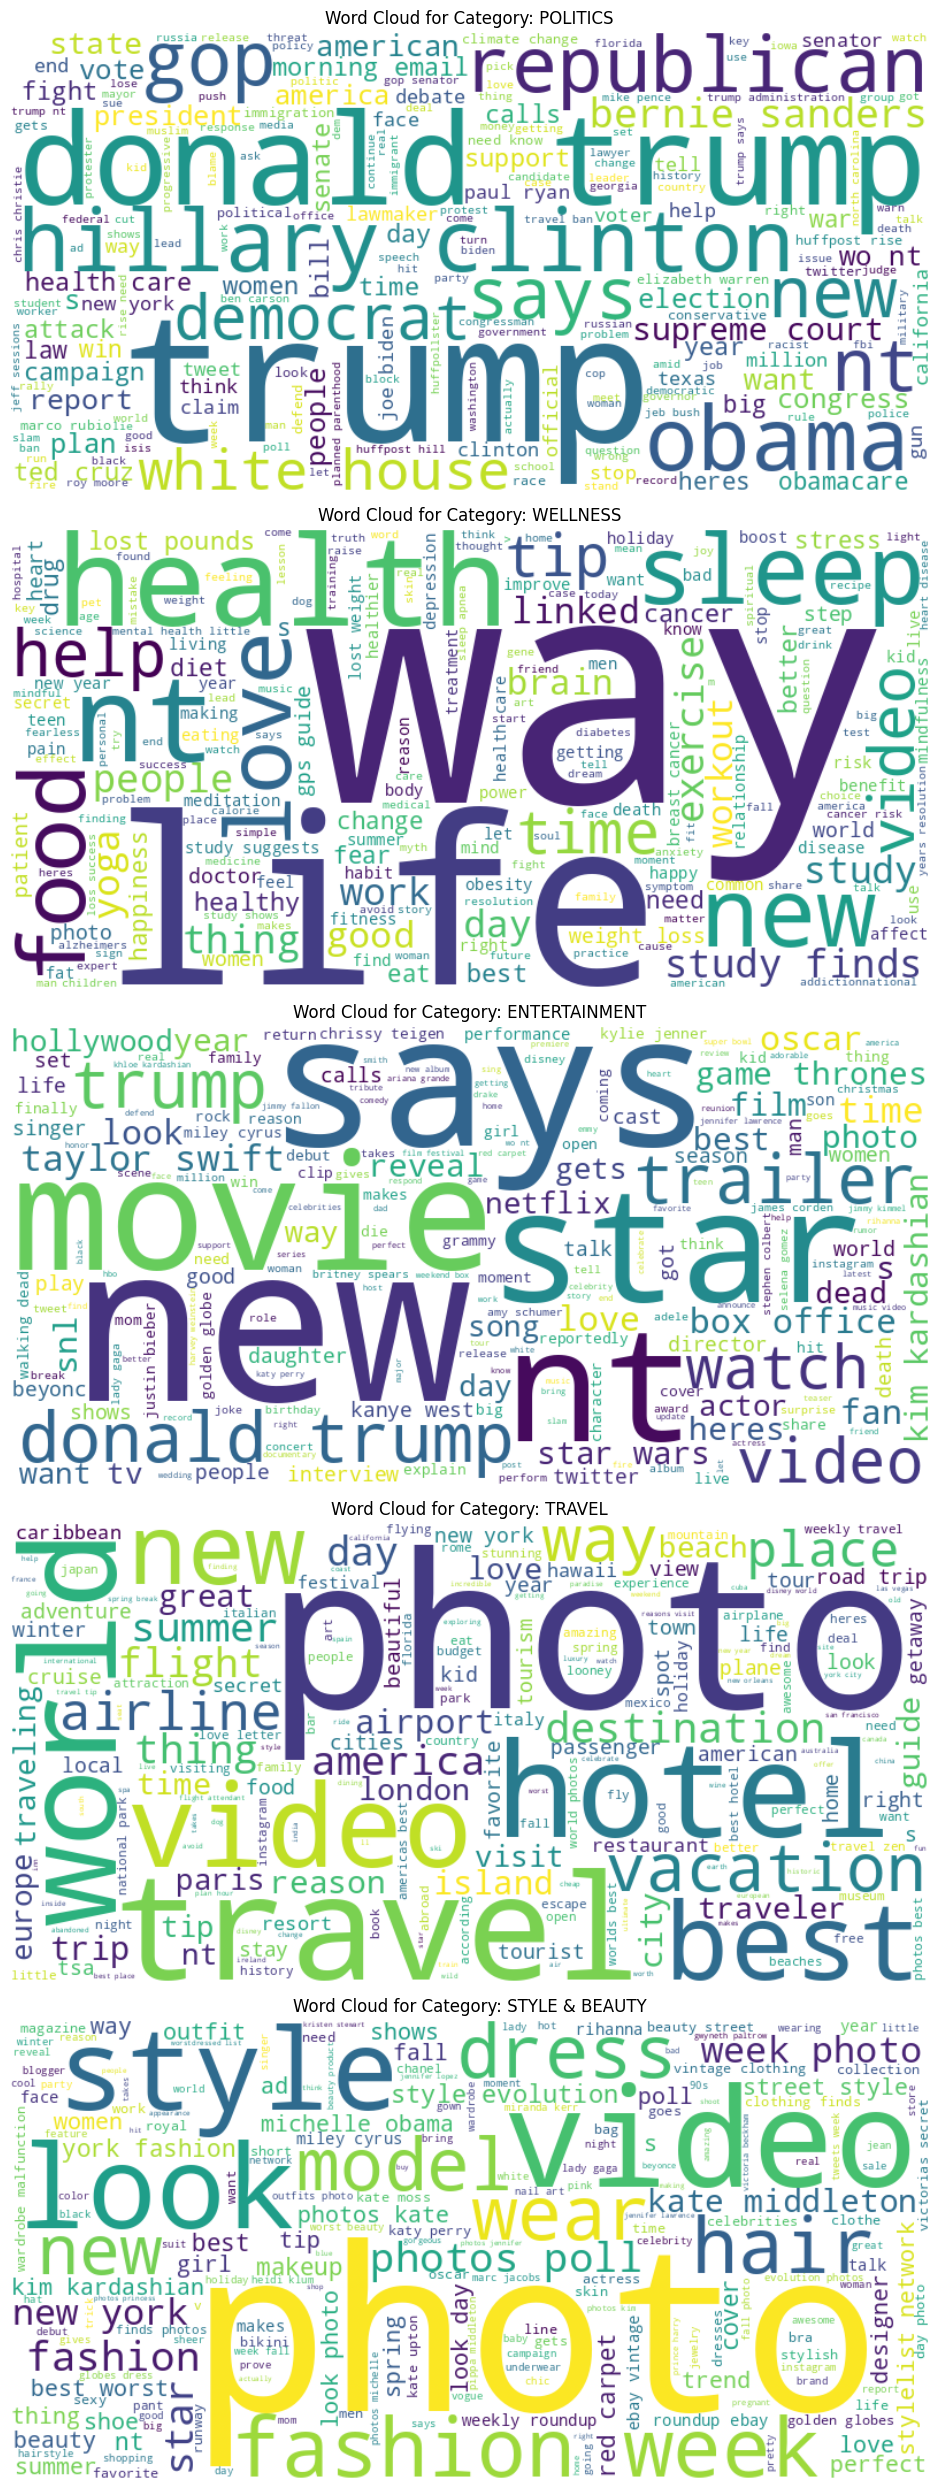

In [ ]:
import re
import spacy
# Function to generate word cloud for a given category
def generate_wordcloud(category, ax): # Pass the subplot axis
    text = ' '.join(df[df['category'] == category]['headline'].tolist())
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = len(text) + 100
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    text = " ".join(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud on the provided subplot axis
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for Category: {category}')


# Generate word clouds for the top 5 categories using subplots
top_5_categories = df['category'].value_counts().nlargest(5).index

# Create a figure and an array of subplots
fig, axes = plt.subplots(len(top_5_categories), 1, figsize=(10, 5 * len(top_5_categories)))

# Iterate through categories and plot on each subplot
for i, category in enumerate(top_5_categories):
    generate_wordcloud(category, axes[i])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Data Preprocesssing before applying BERT and ROBERTA model

Combining short description and headline as full description

In [ ]:
df['full_description'] = df['headline'].str.strip() + ' ' + df['short_description'].str.strip()
df.head()

,link,headline,category,short_description,authors,date,full_description
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...


Dropping unnecessary variables

In [ ]:
df = df.drop(["link", "headline", "short_description","date","authors"], axis=1)
df.head()

,category,full_description
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...


Removing stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define a function to remove stopwords from text
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply stopwords removal to your DataFrame
df['full_description'] = df['full_description'].apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,category,full_description
0,U.S. NEWS,4 million americans roll sleeves omicron-targe...
1,U.S. NEWS,"american airlines flyer charged, banned life p..."
2,COMEDY,23 funniest tweets cats dogs week (sept. 17-23...
3,PARENTING,"funniest tweets parents week (sept. 17-23) ""ac..."
4,U.S. NEWS,woman called cops black bird-watcher loses law...
...,...,...
209522,TECH,rim ceo thorsten heins' 'significant' plans bl...
209523,SPORTS,maria sharapova stunned victoria azarenka aust...
209524,SPORTS,"giants patriots, jets colts among improbable s..."
209525,SPORTS,aldon smith arrested: 49ers linebacker busted ...


Cnverting upper case to lower case

In [ ]:
df['full_description'] = df['full_description'].apply(lambda descr: str(descr).lower())
df.head()

,category,full_description
0,U.S. NEWS,4 million americans roll sleeves omicron-targe...
1,U.S. NEWS,"american airlines flyer charged, banned life p..."
2,COMEDY,23 funniest tweets cats dogs week (sept. 17-23...
3,PARENTING,"funniest tweets parents week (sept. 17-23) ""ac..."
4,U.S. NEWS,woman called cops black bird-watcher loses law...


## BERT

Splitting train and test data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
X = df[['full_description']]
y = df['category']

# Initialize StratifiedShuffleSplit
n_splits = 1
stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)

# Iterate over the split indices
for train_index, test_index in stratified_split.split(X, y):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

Encoding 'Category' variable using label encoder
Tokenize the full description variable

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'category' column to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])

# Define the DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels) # Set num_labels to the correct number of classes

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=128)
    return tokens

train_df['TokenizedText'] = train_df['full_description'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['full_description'].apply(tokenize_text)



# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())

<ipython-input-9-2eb0969d5566>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['category'] = label_encoder.fit_transform(train_df['category'])
<ipython-input-9-2eb0969d5566>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['category'] = label_encoder.transform(test_df['category'])
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in yo

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-2eb0969d5566>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TokenizedText'] = train_df['full_description'].apply(tokenize_text)
<ipython-input-9-2eb0969d5566>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Fine-tuning the BERT model using Adam optimiser and dataloader

In [ ]:
# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Running the model for training dataset in 2 epochs

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Attention mask added by default
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Training loop for one epoch
for epoch in range(2):  # Run for 2 epochs
    train_loss = train(model, train_dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")

Training: 100%|██████████| 9821/9821 [22:49<00:00,  7.17it/s]


Epoch 1/2, Train Loss: 1.4906


Training: 100%|██████████| 9821/9821 [22:54<00:00,  7.15it/s]

Epoch 2/2, Train Loss: 1.0353


Running the model on test data set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluate the model on the test dataset
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Inverse transform the numerical labels back to original labels
y_true_orig_labels = label_encoder.inverse_transform(y_true)
y_pred_orig_labels = label_encoder.inverse_transform(y_pred)

Evaluating: 100%|██████████| 6548/6548 [02:23<00:00, 45.78it/s]


Confusion matrix for original and predicted data

Confusion Matrix:
[[177   5   9 ...   9   0   5]
 [  0 139  10 ...  13   1   0]
 [  1   7 554 ...  12   1   2]
 ...
 [  1   5   8 ... 392   2   0]
 [  0   2   2 ...   7 274  19]
 [  3   1   1 ...   1   3 411]]


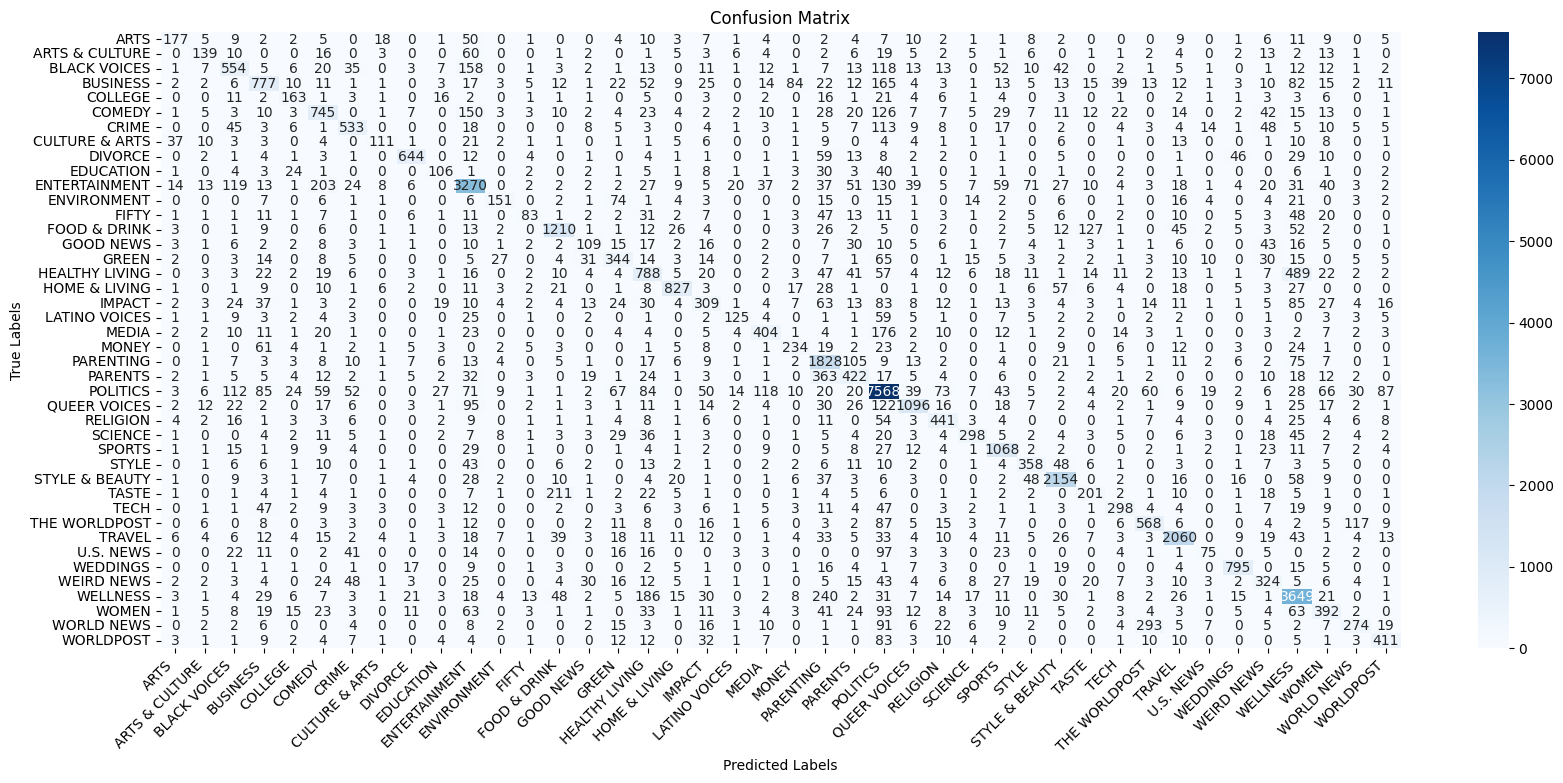

In [ ]:
# Calculate confusion matrix and classification report
cm = confusion_matrix(y_true_orig_labels, y_pred_orig_labels)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.show()


Classification report - Precision, Recall, F1 score and support of actual and predicted data

In [ ]:
# Calculate classification report
report = classification_report(y_true_orig_labels, y_pred_orig_labels)
print("Classification Report:")
print(report)


Classification Report:
                precision    recall  f1-score   support

          ARTS       0.64      0.47      0.54       377
ARTS & CULTURE       0.58      0.41      0.48       335
  BLACK VOICES       0.52      0.48      0.50      1146
      BUSINESS       0.61      0.52      0.56      1498
       COLLEGE       0.53      0.57      0.55       286
        COMEDY       0.56      0.55      0.56      1350
         CRIME       0.65      0.60      0.62       891
CULTURE & ARTS       0.66      0.41      0.51       268
       DIVORCE       0.86      0.75      0.80       857
     EDUCATION       0.50      0.42      0.46       253
 ENTERTAINMENT       0.74      0.75      0.75      4341
   ENVIRONMENT       0.64      0.42      0.51       361
         FIFTY       0.57      0.24      0.34       350
  FOOD & DRINK       0.75      0.76      0.75      1585
     GOOD NEWS       0.42      0.31      0.36       349
         GREEN       0.48      0.52      0.50       656
HEALTHY LIVING       0.5

Accuracy of BERT Model

In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true_orig_labels, y_pred_orig_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Overall Accuracy: 0.6889


## Roberta

Since ROBERTA model runs on GPU, the entire dataset will take more time to run in google colab. So I reduced the dataset to 50000 rows

In [ ]:
#!pip install datasets
import datasets
# Convert the Pandas DataFrame to a Hugging Face Dataset
dataset = datasets.Dataset.from_pandas(df)

# shuffle method
shuffled_dataset = dataset.shuffle(seed=42)

# Select the first 50000 rows
selected_dataset = shuffled_dataset.select(range(50000))

df = selected_dataset.to_pandas()
df

,category,full_description,__index_level_0__
0,POLITICS,going way: public opinion premarital sex next ...,30546
1,ENTERTAINMENT,beyoncé postpones nashville show days formatio...,68599
2,WOMEN,kathy griffin sick 'same middle-age white guys...,122853
3,ENTERTAINMENT,jeffrey tambor hints we’ll wait ‘arrested deve...,44071
4,POLITICS,high schoolers investigated principal visit d....,36693
...,...,...,...
49995,GREEN,climate post: next stop road climate agreement...,107597
49996,POLITICS,jared kushner testify behind closed doors russ...,29348
49997,CRIME,robert christina forbes arrested cockroach fou...,173555
49998,HEALTHY LIVING,snack maximize weekend workouts refueling exer...,104258


Splitting data into train, test data after encoding the 'Category' variable

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

# Preprocessing
X = df['full_description'].astype(str)  # Convert to string to avoid tokenization errors
y = df['category']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Configuring Roberta model

In [ ]:
# Initialize tokenizer and model
model_name = "roberta-base"  # Use "roberta-large" for larger models
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Tokenising the data

In [ ]:
# Tokenization function
def tokenize_function(texts, labels, tokenizer, max_length=128):
    tokens = tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return tokens['input_ids'], tokens['attention_mask'], torch.tensor(labels)

# Tokenize train and test data
X_train_tokens, X_train_masks, y_train = tokenize_function(X_train, y_train, tokenizer)
X_test_tokens, X_test_masks, y_test = tokenize_function(X_test, y_test, tokenizer)

Fine-tuning Roberta model using dataloader and Adam optimiser

In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(X_train_tokens, X_train_masks, y_train)
test_dataset = TensorDataset(X_test_tokens, X_test_masks, y_test)

# DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and scheduler
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Scheduler for learning rate
num_epochs = 5
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Running the model on the train and test set and calculating the accuracy

In [ ]:
# Training loop
criterion = torch.nn.CrossEntropyLoss()
progress_bar = tqdm(range(num_training_steps))

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_dataloader:
        # Move batch to device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Track metrics
        epoch_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        progress_bar.update(1)

    train_loss = epoch_loss / len(train_dataloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Evaluation loop
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataloader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/23440 [00:00<?, ?it/s]

Epoch 1/5: Loss = 1.7723, Accuracy = 0.5330
Epoch 2/5: Loss = 1.2608, Accuracy = 0.6452
Epoch 3/5: Loss = 0.9565, Accuracy = 0.7210
Epoch 4/5: Loss = 0.7153, Accuracy = 0.7844
Epoch 5/5: Loss = 0.5036, Accuracy = 0.8473
Test Loss: 1.3008, Test Accuracy: 0.6574


**Observations:**
It can be found that BERT gives higher accuracy of 68% than ROBERTA model which is of 65% (with 50000 instances)

**Future Work:**
The models can be optimised more with dropout layers, weight decay and optimisation function etc, so that higher accuracy is achieved